<a href="https://colab.research.google.com/github/TonyQ2k3/pytorch-training/blob/main/notebooks/pytorch_day6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Day 6
---

## Preparing a multi-class dataset

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.05,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

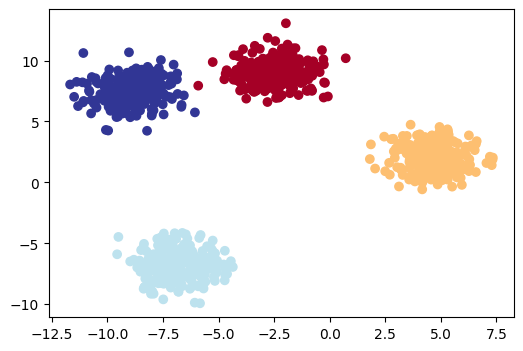

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

## Building the model

Back to theory, for a multi-class model we need:
+ Input layer shape: Number of features
+ Num of hidden layers: *Depends*
+ Neuron / hidden layer: *Depends*
+ Hidden layer activation: ReLU
+ Output layer shape: Number of classes
+ Output activation: Softmax
+ Loss function: Cross-Entropy
+ Optimizer: SGD, ADAM

In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.hidden_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )

  def forward(self, x):
    return self.hidden_stack(x)

In [ ]:
model = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=8
)

## Training the model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
train_losses = []
test_losses = []

In [ ]:
torch.manual_seed(RANDOM_SEED)
epochs = 100

for epoch in range(epochs):
  model.train()
  y_logits = model(X_train)
  loss = loss_fn(y_logits, y_train)
  train_losses.append(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    y_logits_test = model(X_test)
    test_loss = loss_fn(y_logits_test, y_test)
    test_losses.append(test_loss.item())

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}| Loss: {loss}")

Epoch: 0| Loss: 1.1528030633926392
Epoch: 10| Loss: 0.6240651607513428
Epoch: 20| Loss: 0.39261195063591003
Epoch: 30| Loss: 0.2090320736169815
Epoch: 40| Loss: 0.07478321343660355
Epoch: 50| Loss: 0.036670535802841187
Epoch: 60| Loss: 0.024285564199090004
Epoch: 70| Loss: 0.018322408199310303
Epoch: 80| Loss: 0.014847270213067532
Epoch: 90| Loss: 0.012611081823706627


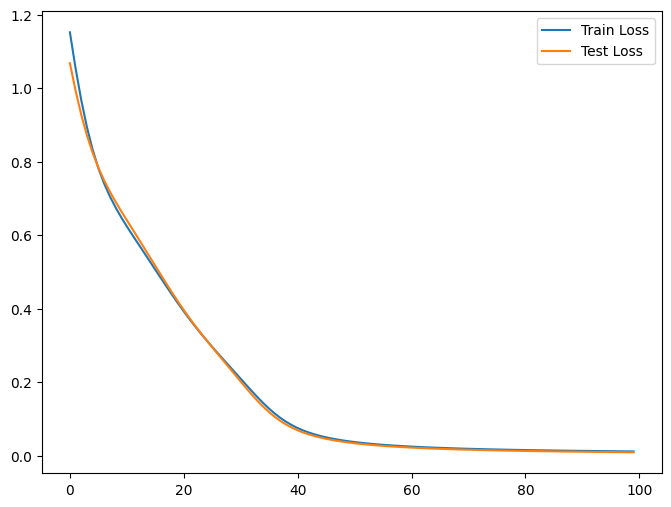

In [ ]:
eps =  [x for x in range(epochs)]
plt.figure(figsize=(8, 6))
plt.plot(eps, train_losses, label="Train Loss")
plt.plot(eps, test_losses, label="Test Loss")
plt.legend()
plt.show()

In [ ]:
# Download helper function
import requests
from pathlib import Path

if Path("helper_functions.py").is_file() is not True:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

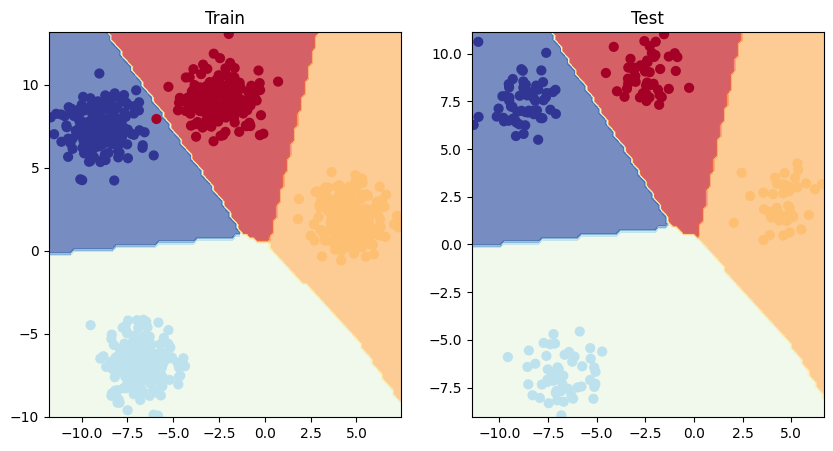

In [ ]:
# Visualize result
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In [ ]:
# View the accuracy
model.eval()
with torch.inference_mode():
  y_logits = model(X_test)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
  acc = accuracy_fn(y_test, y_preds)
  print(f"Accuracy: {acc}%")

Accuracy: 100.0%


## Model troubleshooting and improving

To improve a model, you may adjust:
+ Number of hidden layers
+ Number of neurons
+ Change activation function between layers
+ Change loss function / optimizer

## Classification model evaluation


The 3 metrics for classification evaluation are:

### 1. Accuracy
+ The number of correct prediction / Total of predictions
+ Formula: $(Tp + Tn) / (Tp + Fp + Tn + Fn)$
+ Not ideal for data with imbalanced classes

### 2. Precision
+ The number of "positive" predictions being right, over the total of "positive" prediction.
+ Higher precision means less "False Positive" cases.
+ Formula: $ Tp / (Tp + Fp) $

### 3. Recall
+ The number of "positive" predictions being right, over the total of "positive" cases.
+ Higher recall means less "Positive" cases get ignored (less False Negative)
+ Formula: $ Tp / (Tp + Fn) $

## Relationship of metrics


### Generalisation
1. Accuracy: General evaluation of the model's accuracy
2. Precision: Evaluate the accuracy of the model's "Positive" predictions.
3. Recall: Evaluate the model's ability to detect "True Positive" case

### Precision vs Recall
There's usually a trade-off between Prec and Rec, so people would usually use F1 Score - the in-between of Precision and Recall